In [1]:
from __future__ import print_function, division
import copy
import torch
import argparse
import numpy as np
import umap
import os
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
f1_score, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from scipy.stats import ttest_ind
from scipy.spatial import distance_matrix

import argparse
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.ensemble import GradientBoostingRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear
from pytorchtools import EarlyStoppingCAC

import numbers
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari,\
silhouette_score, mutual_info_score
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

from models import MultiHeadIDEC,  target_distribution
# from utils import *

# Utils.py

In [62]:
## Utils.py
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from sklearn.datasets import make_classification, make_blobs
from sklearn.metrics.cluster import silhouette_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from scipy.optimize import linear_sum_assignment as linear_assignment
from scipy.stats import ttest_ind
from read_patients import get_aki
import sys

color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

DATASETS = ['diabetes', 'respiratory', 'cic', 'sepsis', 'kidney', 'infant', 'wid_mortality', 'synthetic']

DATA_DIR = "/Users/shivin/Document/NUS/Research/Data/"
BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/DeepCAC/"

# # Disable Print
# def blockPrint():
#     sys.stdout = open(os.devnull, 'w')


# # Restore Print
# def enablePrint():
#     sys.stdout = sys.__stdout__


def calculate_bound(model, B, m):
    sum1 = 0
    for j in range(model.n_clusters):
        prod = 1.0
        for param in model.classifiers[j][0].parameters():
            prod *= torch.norm(param.view(-1))
        sum1 += B[j]*prod
    x = sum1/np.sqrt(model.n_clusters*m)
    return x.item()


def silhouette_new(X, labels, metric="euclidean"):
    if len(np.unique(labels)) == 1:
        return 0
    else:
        return silhouette_score(X, labels, metric=metric)


def calculate_nhfd(X, cluster_ids):
    feature_diff = 0
    cntr = 0
    n_clusters = len(torch.unique(cluster_ids))
    input_dim = X.shape[1]
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i > j:
                ci = torch.where(cluster_ids == i)[0]
                cj = torch.where(cluster_ids == j)[0]
                Xi = X[ci]
                Xj = X[cj]
                feature_diff += sum(ttest_ind(Xi, Xj, axis=0)[1] < 0.05)/input_dim
                # feature_diff += torch.nn.functional.kl_div(Xi.log(), Xj, reduction='batchmean')
                cntr += 1
    if cntr == 0:
        return 0
    return feature_diff/cntr


def calc_MI(x, y, bins=10):
    minn = min(np.min(x), np.min(y))
    maxx = max(np.max(x), np.max(y))
    h1 = np.histogram(x, np.arange(minn, maxx, 0.1))[0]
    h2 = np.histogram(y, np.arange(minn, maxx, 0.1))[0]
    c_xy = np.histogram2d(h1, h2, bins)[0]
    if np.sum(c_xy) == 0:
        return 0
    # print(minn, maxx)
    # print(h1, h2, x, y)
    # print(c_xy)
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi


def calculate_MIFD(X, cluster_ids):
    cluster_entrpy = 0
    cntr = 0
    n_columns = X.shape[1]
    n_clusters = len(torch.unique(cluster_ids))
    input_dim = X.shape[1]
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i > j:
                ci = torch.where(cluster_ids == i)[0]
                cj = torch.where(cluster_ids == j)[0]
                Xi = X[ci]
                Xj = X[cj]
                col_entrpy = 0
                for c in range(n_columns):
                    col_entrpy += calc_MI(Xi[:,c], Xj[:,c])
                cluster_entrpy += col_entrpy/n_columns
                cntr += 1
    if cntr == 0:
        return 0
    return cluster_entrpy/cntr


def load_mnist(path='./data/mnist.npz'):
    f = np.load(path)

    x_train, y_train, x_test, y_test = f['x_train'], f['y_train'], f[
        'x_test'], f['y_test']
    f.close()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test)).astype(np.int32)
    x = x.reshape((x.shape[0], -1)).astype(np.float32)
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)
    return x, y


class MnistDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_mnist()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


def load_mnist(path='./data/mnist.npz'):
    f = np.load(path)

    x_train, y_train, x_test, y_test = f['x_train'], f['y_train'], f[
        'x_test'], f['y_test']
    f.close()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test)).astype(np.int32)
    x = x.reshape((x.shape[0], -1)).astype(np.float32)
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)
    return x, y


class MnistDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_mnist()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


def is_non_zero_file(fpath):
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0



class parameters(object):
    def __init__(self, parser):
        self.input_dim = -1
        self.dataset = parser.dataset
        
        # Training parameters
        self.lr = parser.lr
        self.alpha = float(parser.alpha)
        self.wd = parser.wd
        self.batch_size = parser.batch_size
        self.n_epochs = parser.n_epochs
        self.pre_epoch = parser.pre_epoch
        self.pretrain = parser.pretrain
        self.load_ae = parser.load_ae
        self.classifier = parser.classifier
        self.tol = parser.tol
        self.attention = parser.attention == "True"
        self.ablation = parser.ablation
        self.cluster_balance = parser.cluster_balance

        # Model parameters
        self.lamda = parser.lamda
        self.beta = parser.beta
        self.gamma = parser.gamma
        self.delta = parser.delta
        self.hidden_dims = parser.hidden_dims
        self.latent_dim = self.n_z = parser.n_z
        self.n_clusters = parser.n_clusters
        self.clustering = parser.clustering
        self.n_classes = parser.n_classes

        # Utility parameters
        self.device = parser.device
        self.log_interval = parser.log_interval
        self.pretrain_path = parser.pretrain_path + "/" + self.dataset + ".pth"


#######################################################
# Evaluate Critiron
#######################################################


def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row, col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row, col)]) * 1.0 / y_pred.size


def plot(model, X_train, y_train, X_test=None, y_test=None, labels=None):
    reducer = umap.UMAP(random_state=42)
#     idx = torch.Tensor(np.random.randint(0,len(X_train),\
#                         int(0.1*len(X_train)))).type(torch.LongTensor).to(device)
    idx = range(int(0.2*len(X_train)))
    qs, latents_X = model(X_train[idx], output="latent")
    q_train = qs[0]
    y_train = y_train[idx]

    if labels is not None:
        cluster_id_train = labels[idx]
    else:
        cluster_id_train = torch.argmax(q_train, axis=1)

    X2 = reducer.fit_transform(latents_X.cpu().detach().numpy())

    print("Training data")

    c_clusters = [color[int(cluster_id_train[i])] for i in range(len(cluster_id_train))]
    c_labels = [color[int(y_train[i])] for i in range(len(cluster_id_train))]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Clusters vs Labels')
    ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
    ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
    plt.show()
    if X_test is not None:
        qs, latents_test = model(X_test, output="latent")
        q_test = qs[0]
        X2 = reducer.transform(latents_test.cpu().detach().numpy())
        cluster_id_test = torch.argmax(q_test, axis=1)
        c_clusters = [color[int(cluster_id_test[i])] for i in range(len(cluster_id_test))]
        c_labels = [color[int(y_test[i])] for i in range(len(cluster_id_test))]

        print("Test data")
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()


def get_dataset(DATASET, DATA_DIR):
    if DATASET == "cic":
        Xa = pd.read_csv(DATA_DIR + "/CIC/cic_set_a.csv")
        Xb = pd.read_csv(DATA_DIR + "/CIC/cic_set_b.csv")
        Xc = pd.read_csv(DATA_DIR + "/CIC/cic_set_c.csv")

        ya = Xa['In-hospital_death']
        yb = Xb['In-hospital_death']
        yc = Xc['In-hospital_death']

        Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

        cols = Xa.columns

        scale = StandardScaler()
        Xa = scale.fit_transform(Xa)
        Xb = scale.transform(Xb)
        Xc = scale.transform(Xc)

        Xa = pd.DataFrame(Xa, columns=cols)
        Xb = pd.DataFrame(Xb, columns=cols)
        Xc = pd.DataFrame(Xc, columns=cols)

        Xa = Xa.fillna(0)
        Xb = Xb.fillna(0)
        Xc = Xc.fillna(0)

        X_train = pd.concat([Xa, Xb])
        y_train = pd.concat([ya, yb])

        X_test = Xc
        y_test = yc

        X = pd.concat([X_train, X_test]).to_numpy()
        y = pd.concat([y_train, y_test]).to_numpy()
        columns = cols

    elif DATASET == "titanic":
        X_train = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X_train.csv")
        columns = X_train.columns
        X_train = X_train.to_numpy()
        X_test = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X_test.csv").to_numpy()
        y_train = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y_train.csv").to_numpy()
        y_test = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y_test.csv").to_numpy()

        X = np.vstack([X_train, X_test])
        y = np.vstack([y_train, y_test])
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        # X = pd.concat([X_train, X_test]).to_numpy()
        # y = pd.concat([y_train, y_test]).to_numpy()
    
    elif DATASET == "infant":
        X = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X.csv")
        columns = X.columns
        X = X.to_numpy()
        y = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        y = y.astype(int)
        enc = OneHotEncoder(handle_unknown='ignore')
        X = enc.fit_transform(X).toarray()

    else:
        X = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X.csv")
        columns = X.columns
        X = X.to_numpy()
        y = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
    return X, y, columns


def create_imbalanced_data_clusters(n_samples=1000, n_features=8, n_informative=5, n_classes=2,\
                            n_clusters = 2, frac=0.4, outer_class_sep=0.5, inner_class_sep=0.2, clus_per_class=2, seed=0):
    np.random.seed(seed)
    X = np.empty(shape=n_features)
    Y = np.empty(shape=1)
    offsets = np.random.normal(0, outer_class_sep, size=(n_clusters, n_features))
    for i in range(n_clusters):
        samples = int(np.random.normal(n_samples, n_samples/10))
        x, y = make_classification(n_samples=samples, n_features=n_features, n_informative=n_informative,\
                                    n_classes=n_classes, class_sep=inner_class_sep, n_clusters_per_class=clus_per_class)
                                    # n_repeated=0, n_redundant=0)
        x += offsets[i]
        y_0 = np.where(y == 0)[0]
        y_1 = np.where(y != 0)[0]
        y_1 = np.random.choice(y_1, int(np.random.normal(frac, frac/4)*len(y_1)))
        index = np.hstack([y_0,y_1])
        np.random.shuffle(index)
        x_new = x[index]
        y_new = y[index]

        X = np.vstack((X,x_new))
        Y = np.hstack((Y,y_new))

    X = pd.DataFrame(X[1:,:])
    Y = Y[1:]
    columns = ["feature_"+str(i) for i in range(n_features)]
    return X, np.array(Y).astype('int'), columns


def get_train_val_test_loaders(args):
    if args.dataset in DATASETS:
        if args.dataset != "kidney" and args.dataset != "respiratory":
            print("Loading Dataset ", args.dataset)
            if args.dataset == "synthetic":
                n_feat = 45
                X, y, columns = create_imbalanced_data_clusters(n_samples=5000,\
                       n_clusters=args.n_clusters, n_features = n_feat,\
                       inner_class_sep=0.2, outer_class_sep=2, seed=0)
                args.input_dim = n_feat

            elif args.dataset == "paper_synthetic":
                n_feat = 100
                X, y = paper_synthetic(2500, centers=4)
                args.input_dim = n_feat
                print(args.input_dim)

            else:
                X, y, columns = get_dataset(args.dataset, DATA_DIR)
                print(args.dataset)
                args.input_dim = X.shape[1]

            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_val = sc.fit_transform(X_val)
            X_test = sc.fit_transform(X_test)
            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))

        elif args.dataset == "kidney":
            print("Loading Kidney Train")
            X_train, y_train, columns = get_dataset(args.dataset, DATA_DIR + "aki/train")
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            args.input_dim = X_train.shape[1]
            print(args.input_dim)

            print("Loading Kidney Test")
            X_test, y_test, columns = get_dataset(args.dataset, DATA_DIR + "aki/test")

            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))

        else:
            print("Loading Repiratory Train")
            X_train, y_train, columns = get_dataset(args.dataset, DATA_DIR + "ards/train")
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            args.input_dim = X_train.shape[1]
            print(args.input_dim)

            print("Loading Respiratory Test")
            X_test, y_test, columns = get_dataset(args.dataset, DATA_DIR + "ards/test")

            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))
            
        train_loader = torch.utils.data.DataLoader(X_train_data_loader,
            batch_size=args.batch_size, shuffle=True)

        val_loader = torch.utils.data.DataLoader(X_val_data_loader,
            batch_size=args.batch_size, shuffle=True)

        test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
            batch_size=args.batch_size, shuffle=False)

        return columns, (X_train, y_train, train_loader), (X_val, y_val, val_loader), (X_test, y_test, test_loader)
    else:
        return None


def paper_synthetic(n_pts=1000, centers=4):
    X, y = make_blobs(n_pts, centers=centers)
    W = np.random.randn(10,2)
    U = np.random.randn(100,10)
    X1 = W.dot(X.T)
    X1 = X1*(X1>0)
    X2 = U.dot(X1)
    X2 = X2*(X2>0)
    return X2.T, y

## Ablation Parameter Ranges ##
betas = [0, 0.001, 0.002, 0.005, 0.008, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
gammas = [0, 0.001, 0.002, 0.005, 0.008, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
deltas = [0, 0.001, 0.002, 0.005, 0.008, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
ks = [1, 2, 3, 4, 5]

In [3]:
import numpy as np
import torch

class EarlyStoppingCAC:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='./pretrained_model/checkpoint', dataset="", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = [None, None]
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path + "_" + dataset
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score[0] is None:
            self.best_score[0] = score[0]
            self.save_checkpoint(val_loss, model)

        if self.best_score[1] is None:
            self.best_score[1] = score[1]
            self.save_checkpoint(val_loss, model)

        if score[1] < self.best_score[1] + self.delta :
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.ae.state_dict(), self.path+".pt")
        for j in range(model.n_clusters):
            torch.save(model.classifiers[j][0].state_dict(), self.path+"_"+str(j)+".pt")
        self.val_loss_min = val_loss
        torch.save(model.cluster_layer, self.path+"_cc"+".pt")
        torch.save(model.p_cluster_layer, self.path+"_pc"+".pt")
        torch.save(model.n_cluster_layer, self.path+"_nc"+".pt")

    def load_checkpoint(self, model):
        print("Loading Best model with score: ", self.best_score)
        model.ae.load_state_dict(torch.load(self.path+".pt"))
        for j in range(model.n_clusters):
            model.classifiers[j][0].load_state_dict(torch.load(self.path+"_"+str(j)+".pt"))
        model.cluster_layer = torch.load(self.path+"_cc"+".pt")
        model.p_cluster_layer = torch.load(self.path+"_pc"+".pt")
        model.n_cluster_layer = torch.load(self.path+"_nc"+".pt")
        return model


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='./pretrained_model/checkpoint', dataset="", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = [None, None]
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path + "_" + dataset
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score[0] is None:
            self.best_score[0] = score[0]
            self.save_checkpoint(val_loss, model)

        if self.best_score[1] is None:
            self.best_score[1] = score[1]
            self.save_checkpoint(val_loss, model)

        if score[1] < self.best_score[1] + self.delta :
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path+".pt")
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        print("Loading Best model with score: ", self.best_score)
        model.load_state_dict(torch.load(self.path+".pt"))
        return model

In [64]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear
import torch
from utils import is_non_zero_file

class AE(nn.Module):
    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 input_dim, n_z):
        super(AE, self).__init__()

        # encoder
        self.enc_1 = Linear(input_dim, n_enc_1)
        self.enc_2 = Linear(n_enc_1, n_enc_2)
        self.enc_3 = Linear(n_enc_2, n_enc_3)

        self.z_layer = Linear(n_enc_3, n_z)

        # decoder
        self.dec_1 = Linear(n_z, n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.dec_3 = Linear(n_dec_2, n_dec_3)

        self.x_bar_layer = Linear(n_dec_3, input_dim)

    def forward(self, x, output="decoded"):

        # encoder
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        enc_h3 = F.relu(self.enc_3(enc_h2))

        z = self.z_layer(enc_h3)
        if output == "latent":
            return z

        # decoder
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        dec_h3 = F.relu(self.dec_3(dec_h2))
        x_bar = self.x_bar_layer(dec_h3)

        return x_bar, z


def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()


def source_distribution(z, cluster_layer, alpha=1):
    q = 1.0 / (1.0 + torch.sum(
        torch.pow(z.unsqueeze(1) - cluster_layer, 2), 2) / alpha)
    q = q.pow((alpha + 1.0) / 2.0)
    q = (q.t() / torch.sum(q, 1)).t()
    return q


def pretrain_ae(model, train_loader, args):
    '''
    pretrain autoencoder
    '''
    print(model)
    optimizer = Adam(model.parameters(), lr=args.lr)
    for epoch in range(50):
        total_loss = 0.
        for batch_idx, (x, _, _) in enumerate(train_loader):
            x = x.to(args.device)

            optimizer.zero_grad()
            x_bar, _ = model(x)
            loss = F.mse_loss(x_bar, x)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("Pretraining epoch {} loss={:.4f}".format(epoch,
                                            total_loss / (batch_idx + 1)))
        torch.save(model.state_dict(), args.pretrain_path)
    print("model saved to {}.".format(args.pretrain_path))


class NNClassifier(nn.Module):
    def __init__(self, args, input_dim, ae=None):
        super(NNClassifier, self).__init__()
        self.args = args
        self.n_classes = args.n_classes
        self.criterion = nn.CrossEntropyLoss(reduction='mean')
        self.ae = ae

        if self.ae == None:
            self.input_dim = args.input_dim
        else:
            self.input_dim = args.latent_dim
        if input_dim != None:
            self.input_dim = input_dim

        self.classifier = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, args.n_classes),
        )
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=args.lr)

    def forward(self, inputs):
        if self.ae == None:
            return self.classifier(inputs)
        else:
            input_z = self.ae(inputs, output="latent")
            return self.classifier(input_z)

    def fit(self, X_batch, y_batch):
        self.optimizer.zero_grad()
        self.classifier.train()
        y_pred = self.forward(X_batch.detach())
        train_loss = self.criterion(y_pred, y_batch)
        train_loss.backward()
        self.optimizer.step()
        return y_pred.detach().numpy(), train_loss.item()


class MultiHeadIDEC(nn.Module):
    def __init__(self,
                 n_enc_1,
                 n_enc_2,
                 n_enc_3,
                 n_dec_1,
                 n_dec_2,
                 n_dec_3,
                 args):
        super(MultiHeadIDEC, self).__init__()
        self.alpha = args.alpha
        self.pretrain_path = args.pretrain_path
        self.device = args.device
        self.n_clusters = args.n_clusters
        self.input_dim = args.input_dim
        self.n_z = args.n_z
        self.args = args

        self.ae = AE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_enc_3=n_enc_3,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_dec_3=n_dec_3,
            input_dim=self.input_dim,
            n_z=self.n_z)

        # cluster layer
        self.cluster_layer = torch.Tensor(self.n_clusters, self.n_z)
        self.p_cluster_layer = torch.Tensor(self.n_clusters, self.n_z)
        self.n_cluster_layer = torch.Tensor(self.n_clusters, self.n_z)
        torch.nn.init.xavier_normal_(self.cluster_layer.data)
        torch.nn.init.xavier_normal_(self.p_cluster_layer.data)
        torch.nn.init.xavier_normal_(self.n_cluster_layer.data)
        
        self.classifiers = []
        for _ in range(self.n_clusters):
            classifier = nn.Sequential(
                nn.Linear(self.n_z, 64),
                nn.ReLU(),
                # nn.Linear(128, 64),
                # nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 8),
                nn.ReLU(),
                nn.Linear(8, args.n_classes),
            ).to(self.device)

            # classifier = nn.Sequential(
            #     nn.Linear(self.n_z, 100),
            #     nn.ReLU(),
            #     nn.Linear(100, 100),
            #     nn.ReLU(),
            #     nn.Linear(100, 50),
            #     nn.ReLU(),
            #     nn.Linear(50, args.n_classes),
            # )
            optimizer = torch.optim.Adam(classifier.parameters(), lr=args.lr)
            self.classifiers.append([classifier, optimizer])
            

    def pretrain(self, train_loader, path=''):
        print(path)
        if not is_non_zero_file(path):
            path = ''
        if path == '':
            pretrain_ae(self.ae, train_loader, self.args)
        else:
            # load pretrain weights
            self.ae.load_state_dict(torch.load(self.pretrain_path))
            print('load pretrained ae from', path)


    def predict(self, X_test):
        qs, z_test = self.forward(X_test)
        q_test = qs[0]
        cluster_ids = torch.argmax(q_test, axis=1)
        preds = torch.zeros((self.n_clusters, 2))
        for j in range(self.n_clusters):
            preds[j,:] = self.classifiers[cluster_ids[j]]
        return preds


    def forward(self, x, output="default"):
        x_bar, z = self.ae(x)
        # Cluster
        q   = source_distribution(z, self.cluster_layer, alpha=self.alpha)
        q_p = source_distribution(z, self.p_cluster_layer, alpha=self.alpha)
        q_n = source_distribution(z, self.n_cluster_layer, alpha=self.alpha)

        if output == "latent":
            return (q, q_p, q_n), z

        elif output == "classifier":
            preds = torch.zeros((len(z), 2))
            for j in range(len(z)):
                preds[j,:] = self.classifiers[j](z)
            return preds
        
        else:
            return z, x_bar, (q, q_p, q_n)

In [66]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'cic',

# Training parameters
'lr' : 0.002,
'alpha' : 1,
'wd' : 5e-4,
'batch_size' : 512,
'n_epochs' : 100,
'pre_epoch' : 40,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",
"tol": 0.01,
"attention": "True",

# Model parameters
'lamda' : 1,
'beta' : 0.5, # KL loss/KM loss weight
'gamma' : 1, # Classification loss weight
'delta' : 1.5, # Class Balance weight
'eta' : 0.0, # Class separation weight
'hidden_dims' : [64, 32],
'n_z' : 20,
'n_clusters' : 3,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 2,   
'cluster_balance' : 'hellinger',
'pretrain_path': '/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model'}
# 'pretrain_path': ''}


class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.n_epochs = params['n_epochs']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']
        self.tol = params['tol']
        self.attention = params['attention'] == "True"

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.eta = params['eta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = self.n_z = params['n_z']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']
        self.cluster_balance = params['cluster_balance']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']
        self.pretrain_path = params['pretrain_path'] + "/" + self.dataset + ".pth"

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'aki', 'infant', 'wid_mortality']

In [67]:
suffix = ""
suffix += args.dataset + "_"
suffix += str(args.n_clusters) + "_"
suffix += str(args.attention)

column_names, train_data, val_data, test_data = get_train_val_test_loaders(args)
os.chdir(BASE_DIR)
X_train, y_train, train_loader = train_data
X_val, y_val, val_loader = val_data
X_test, y_test, test_loader = test_data

Loading Dataset  cic
cic


In [41]:
print(len(X_train)+len(X_val)+len(X_test))
print(X_train.shape)
print(sum(y_train)/len(y_train))

12000
(6750, 117)
0.14133333333333334


In [8]:
# X_train_kidney = X_train
# y_train_kidney = y_train
# train_loader_kidney = train_loader
# X_val_kidney = X_val
# y_val_kidney = y_val
# val_loader_kidney = val_loader
# X_test_kidney = X_test
# y_test_kidney = y_test
# test_loader_kidney = test_loader
X_train = X_train_kidney
y_train = y_train_kidney
train_loader = train_loader_kidney
X_val = X_val_kidney
y_val = y_val_kidney
val_loader = val_loader_kidney
X_test = X_test_kidney
y_test = y_test_kidney
test_loader = test_loader_kidney

NameError: name 'X_train_kidney' is not defined

In [8]:
pd.DataFrame(X_train, columns=column_names)

,SAPS-I,SOFA,Length_of_stay,Age,Gender,Height,Weight,CCU,CSRU,SICU,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
0,0.770832,-0.101649,1.094800,0.309861,-1.126133,0.014443,-0.687584,-0.411137,-0.527874,1.605928,...,-1.489278,-0.025645,-0.002033,0.389274,-0.915594,0.938981,-0.516772,0.963687,0.984411,1.464460
1,-0.062360,-0.338981,-0.261159,1.477449,-1.126133,0.014443,-0.786423,-0.411137,-0.527874,-0.622693,...,0.002283,-0.025645,-0.282146,-0.077343,-1.051297,-0.008595,-0.013013,0.013206,0.005821,0.022693
2,-1.228828,-0.101649,-0.487152,-0.332313,0.888652,0.029664,0.206465,-0.411137,1.894390,-0.622693,...,-1.097559,-0.025645,-0.002033,-0.225295,0.386145,1.308358,-0.447348,-1.917657,-1.596249,-1.770497
3,1.270747,1.322345,-0.185828,0.718516,-1.126133,-0.079038,-1.208737,-0.411137,1.894390,-0.622693,...,-0.901699,-0.025645,-0.002033,-0.407389,-0.659267,1.123670,-0.102710,0.871199,0.984411,0.817469
4,-0.728913,-0.576313,0.492152,-1.091245,-1.126133,0.014443,1.136455,2.432280,-0.527874,-0.622693,...,0.002283,-0.025645,-0.002033,-0.464293,1.270724,0.569605,-0.013013,0.013206,0.005821,0.022693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6745,0.270917,-0.576313,-0.637814,1.068793,-1.126133,-0.294311,-1.631052,-0.411137,-0.527874,-0.622693,...,0.002283,12.511250,-0.002033,-0.999195,0.016096,-2.200720,-0.013013,0.013206,0.005821,0.022693
6746,-0.728913,0.135684,-0.185828,-1.675039,0.888652,0.014443,0.166031,-0.411137,-0.527874,-0.622693,...,1.497578,-0.025645,-0.002033,-0.384627,0.016096,0.384917,-0.293625,-0.914522,-1.596249,-0.692178
6747,1.937300,1.322345,0.567483,1.010413,-1.126133,0.014443,-1.316562,-0.411137,-0.527874,-0.622693,...,-0.314121,-0.025645,-0.002033,0.685177,0.016096,-0.353837,-0.581237,1.134433,0.984411,0.386141
6748,-0.395636,-0.338981,-0.637814,-1.733419,-1.126133,0.014443,-0.418021,-0.411137,-0.527874,-0.622693,...,0.002283,-0.025645,-0.002033,-0.578102,-0.639163,-0.723213,-0.013013,0.013206,0.005821,0.022693


In [35]:
# X_train_resp = X_train
# y_train_resp = y_train
# train_loader_resp = train_loader
# X_val_resp = X_val
# y_val_resp = y_val
# val_loader_resp = val_loader
# X_test_resp = X_test
# y_test_resp = y_test
# test_loader_resp = test_loader
X_train = X_train_resp
y_train = y_train_resp
train_loader = train_loader_resp
X_val = X_val_resp
y_val = y_val_resp
val_loader = val_loader_resp
X_test = X_test_resp
y_test = y_test_resp
test_loader = test_loader_resp

NameError: name 'X_train_resp' is not defined

In [68]:
print(column_names)
args.input_dim = X_train.shape[1]
BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/DeepCAC"
os.chdir(BASE_DIR)
print(X_train.shape)

Index(['SAPS-I', 'SOFA', 'Length_of_stay', 'Age', 'Gender', 'Height', 'Weight',
       'CCU', 'CSRU', 'SICU',
       ...
       'SysABP_last', 'TroponinI_last', 'TroponinT_last', 'WBC_last',
       'Weight_last', 'pH_last', 'MechVentStartTime', 'MechVentDuration',
       'MechVentLast8Hour', 'UrineOutputSum'],
      dtype='object', length=117)
(6750, 117)


# MultiHead IDEC

## Initialization

In [80]:
f1_scores, auc_scores, acc_scores , sil_scores, mifd_scores,\
nhfd_scores, w_nhfd_scores = [], [], [], [], [], [], []

# to track the training loss as the model trains
train_losses, e_train_losses = [], []
test_losses, e_test_losses, local_sum_test_losses = [], [], []
model_complexity = []

model = MultiHeadIDEC(
        n_enc_1=128,
        n_enc_2=64,
        n_enc_3=32,
        n_dec_1=32,
        n_dec_2=64,
        n_dec_3=128,
        args=args).to(args.device)

model.pretrain(train_loader, args.pretrain_path)

optimizer = Adam(model.parameters(), lr=args.lr)

# cluster parameter initiate
device = args.device
y = y_train
_, ori_hidden = model.ae(torch.Tensor(X_train).to(args.device))
_, ori_hidden_val = model.ae(torch.Tensor(X_val).to(args.device))

kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
_ = kmeans.fit_predict(ori_hidden.data.cpu().numpy())

ori_cluster_indices = kmeans.labels_
original_cluster_centers = kmeans.cluster_centers_

print(np.bincount(ori_cluster_indices))

ori_val_cluster_indices = kmeans.fit_predict(ori_hidden_val.data.cpu().numpy())

model.cluster_layer.data = torch.tensor(original_cluster_centers).to(device)

## Initialization ##
for i in range(args.n_clusters):
    cluster_idx = np.where(ori_cluster_indices == i)[0]

criterion = nn.CrossEntropyLoss(reduction='sum')

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth
[1889  203 4658]


## Clustering Step

Starting Training
Training data


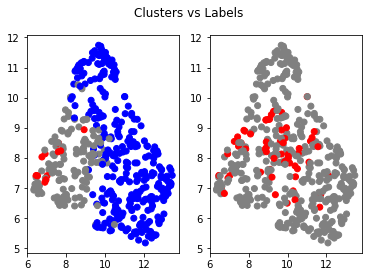

qval tensor([ 786.7525,  151.7287, 1311.5187], grad_fn=<SumBackward1>)
Cluster Counts [ 681   56 1513]
KL div tensor([-262.6171,  -50.9425, -437.5391], grad_fn=<KlDivBackward>)

[  0/100] train_loss: 0.642 valid_loss: 1434.292 valid_F1: 0.024 valid_AUC: 0.517 valid_Feature_p: 0.593 valid_MIFD: 0.314 valid_Silhouette: 0.255 Complexity Term: 0.000
Epoch: 00 | Loss: 76.474 | KM Loss: 670.466 | Classification Loss: 619.044 | Cluster Balance Loss: 4.081
Epoch: 01 | Loss: 125.821 | KM Loss: 416.586 | Classification Loss: 343.977 | Cluster Balance Loss: 2.029
Training data


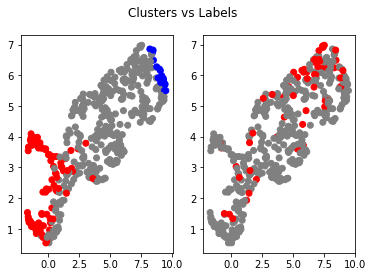

qval tensor([867.0081, 681.8864, 701.1055], grad_fn=<SumBackward1>)
Cluster Counts [1631  516  103]
KL div tensor([-289.3689, -227.6617, -234.0681], grad_fn=<KlDivBackward>)

[  2/100] train_loss: 0.398 valid_loss: 879.462 valid_F1: 0.000 valid_AUC: 0.667 valid_Feature_p: 0.556 valid_MIFD: 0.356 valid_Silhouette: 0.158 Complexity Term: 0.000
Epoch: 02 | Loss: 163.841 | KM Loss: 408.091 | Classification Loss: 314.861 | Cluster Balance Loss: 2.919
Epoch: 03 | Loss: 183.941 | KM Loss: 416.463 | Classification Loss: 310.759 | Cluster Balance Loss: 3.913
Training data


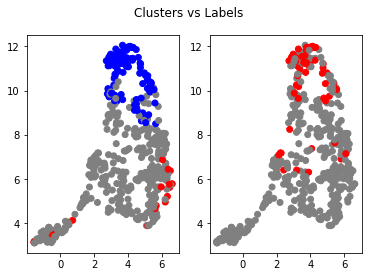

qval tensor([944.9245, 586.3567, 718.7188], grad_fn=<SumBackward1>)
Cluster Counts [1632   91  527]
KL div tensor([-315.3411, -195.8185, -239.9391], grad_fn=<KlDivBackward>)

[  4/100] train_loss: 0.315 valid_loss: 709.810 valid_F1: 0.000 valid_AUC: 0.838 valid_Feature_p: 0.681 valid_MIFD: 0.343 valid_Silhouette: 0.146 Complexity Term: 0.000
Epoch: 04 | Loss: 58.431 | KM Loss: 305.423 | Classification Loss: 264.463 | Cluster Balance Loss: 2.292
Epoch: 05 | Loss: 51.117 | KM Loss: 268.731 | Classification Loss: 233.363 | Cluster Balance Loss: 0.933
Training data


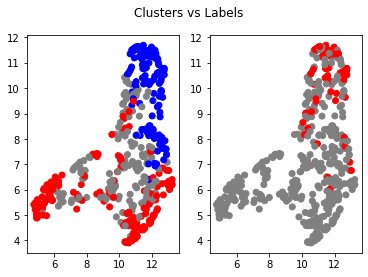

qval tensor([795.1250, 739.7612, 715.1137], grad_fn=<SumBackward1>)
Cluster Counts [785 783 682]
KL div tensor([-265.4079, -246.9533, -238.7375], grad_fn=<KlDivBackward>)

[  6/100] train_loss: 0.278 valid_loss: 678.631 valid_F1: 0.255 valid_AUC: 0.855 valid_Feature_p: 0.678 valid_MIFD: 0.399 valid_Silhouette: 0.100 Complexity Term: 0.000
Epoch: 06 | Loss: 48.647 | KM Loss: 251.715 | Classification Loss: 217.589 | Cluster Balance Loss: 1.196
Epoch: 07 | Loss: 47.105 | KM Loss: 231.787 | Classification Loss: 199.487 | Cluster Balance Loss: 0.630
Training data


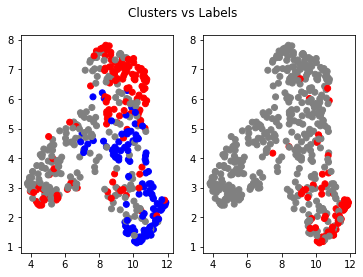

qval tensor([786.1348, 760.3002, 703.5649], grad_fn=<SumBackward1>)
Cluster Counts [858 756 636]
KL div tensor([-262.4112, -253.7996, -234.8879], grad_fn=<KlDivBackward>)

[  8/100] train_loss: 0.241 valid_loss: 671.703 valid_F1: 0.496 valid_AUC: 0.860 valid_Feature_p: 0.704 valid_MIFD: 0.399 valid_Silhouette: 0.075 Complexity Term: 0.000
Epoch: 08 | Loss: 43.325 | KM Loss: 216.736 | Classification Loss: 186.658 | Cluster Balance Loss: 0.479
Epoch: 09 | Loss: 41.098 | KM Loss: 203.952 | Classification Loss: 175.020 | Cluster Balance Loss: 0.455
Training data


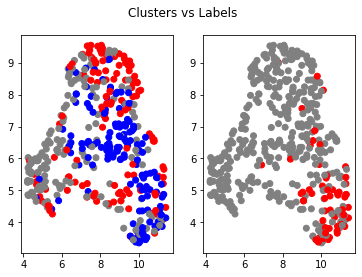

qval tensor([767.9224, 756.3182, 725.7594], grad_fn=<SumBackward1>)
Cluster Counts [698 754 798]
KL div tensor([-256.3403, -252.4723, -242.2860], grad_fn=<KlDivBackward>)

[ 10/100] train_loss: 0.214 valid_loss: 701.083 valid_F1: 0.476 valid_AUC: 0.847 valid_Feature_p: 0.698 valid_MIFD: 0.403 valid_Silhouette: 0.053 Complexity Term: 0.000
EarlyStopping counter: 1 out of 7
Epoch: 10 | Loss: 39.116 | KM Loss: 188.387 | Classification Loss: 160.919 | Cluster Balance Loss: 0.207
Epoch: 11 | Loss: 37.531 | KM Loss: 170.461 | Classification Loss: 143.486 | Cluster Balance Loss: 0.354
Training data


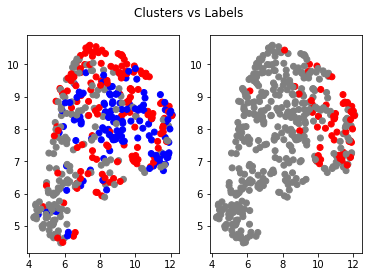

qval tensor([781.7878, 780.8007, 687.4116], grad_fn=<SumBackward1>)
Cluster Counts [763 866 621]
KL div tensor([-260.9622, -260.6331, -229.5034], grad_fn=<KlDivBackward>)

[ 12/100] train_loss: 0.171 valid_loss: 852.363 valid_F1: 0.448 valid_AUC: 0.819 valid_Feature_p: 0.715 valid_MIFD: 0.396 valid_Silhouette: 0.033 Complexity Term: 0.000
EarlyStopping counter: 2 out of 7
Epoch: 12 | Loss: 36.925 | KM Loss: 154.691 | Classification Loss: 127.731 | Cluster Balance Loss: 0.527
Epoch: 13 | Loss: 35.517 | KM Loss: 142.825 | Classification Loss: 116.761 | Cluster Balance Loss: 0.343
Training data


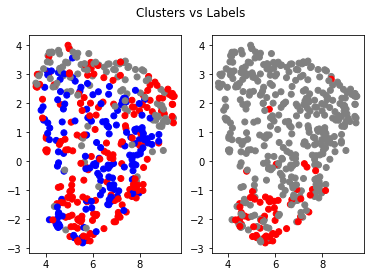

qval tensor([765.0570, 780.2281, 704.7149], grad_fn=<SumBackward1>)
Cluster Counts [ 501 1024  725]
KL div tensor([-255.3852, -260.4423, -235.2712], grad_fn=<KlDivBackward>)

[ 14/100] train_loss: 0.126 valid_loss: 928.049 valid_F1: 0.468 valid_AUC: 0.817 valid_Feature_p: 0.624 valid_MIFD: 0.384 valid_Silhouette: 0.016 Complexity Term: 0.000
EarlyStopping counter: 3 out of 7
Epoch: 14 | Loss: 34.075 | KM Loss: 124.491 | Classification Loss: 99.229 | Cluster Balance Loss: 0.322
Epoch: 15 | Loss: 34.048 | KM Loss: 120.611 | Classification Loss: 95.221 | Cluster Balance Loss: 0.357
Training data


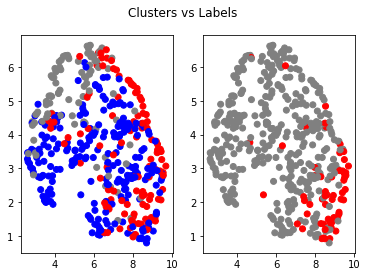

qval tensor([741.1798, 749.3855, 759.4347], grad_fn=<SumBackward1>)
Cluster Counts [ 470  633 1147]
KL div tensor([-247.4261, -250.1614, -253.5111], grad_fn=<KlDivBackward>)

[ 16/100] train_loss: 0.107 valid_loss: 1014.491 valid_F1: 0.436 valid_AUC: 0.809 valid_Feature_p: 0.698 valid_MIFD: 0.395 valid_Silhouette: 0.049 Complexity Term: 0.000
EarlyStopping counter: 4 out of 7
Epoch: 16 | Loss: 33.336 | KM Loss: 100.422 | Classification Loss: 74.954 | Cluster Balance Loss: 0.491
Epoch: 17 | Loss: 32.383 | KM Loss: 89.336 | Classification Loss: 64.873 | Cluster Balance Loss: 0.212
Training data


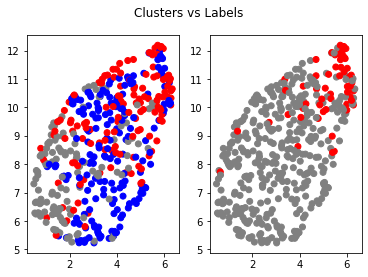

qval tensor([763.4487, 770.6820, 715.8693], grad_fn=<SumBackward1>)
Cluster Counts [629 811 810]
KL div tensor([-254.8491, -257.2602, -238.9893], grad_fn=<KlDivBackward>)

[ 18/100] train_loss: 0.061 valid_loss: 1306.203 valid_F1: 0.479 valid_AUC: 0.816 valid_Feature_p: 0.701 valid_MIFD: 0.394 valid_Silhouette: 0.026 Complexity Term: 0.000
EarlyStopping counter: 5 out of 7
Epoch: 18 | Loss: 31.679 | KM Loss: 74.390 | Classification Loss: 50.300 | Cluster Balance Loss: 0.225
Epoch: 19 | Loss: 31.367 | KM Loss: 66.395 | Classification Loss: 42.571 | Cluster Balance Loss: 0.182
Training data


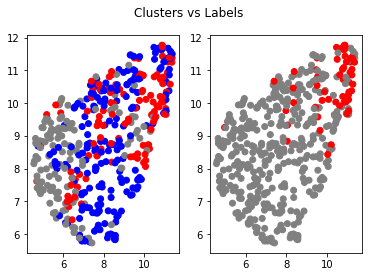

qval tensor([763.6895, 763.2692, 723.0413], grad_fn=<SumBackward1>)
Cluster Counts [729 647 874]
KL div tensor([-254.9294, -254.7893, -241.3800], grad_fn=<KlDivBackward>)

[ 20/100] train_loss: 0.050 valid_loss: 1559.876 valid_F1: 0.484 valid_AUC: 0.806 valid_Feature_p: 0.681 valid_MIFD: 0.392 valid_Silhouette: 0.026 Complexity Term: 0.000
EarlyStopping counter: 6 out of 7
Epoch: 20 | Loss: 31.110 | KM Loss: 61.428 | Classification Loss: 37.775 | Cluster Balance Loss: 0.146
Epoch: 21 | Loss: 31.123 | KM Loss: 53.382 | Classification Loss: 29.640 | Cluster Balance Loss: 0.203
Training data


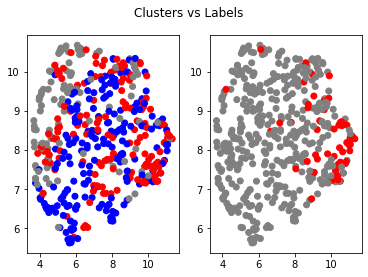

qval tensor([756.9022, 770.8557, 722.2421], grad_fn=<SumBackward1>)
Cluster Counts [533 869 848]
KL div tensor([-252.6669, -257.3181, -241.1136], grad_fn=<KlDivBackward>)

[ 22/100] train_loss: 0.037 valid_loss: 1886.512 valid_F1: 0.438 valid_AUC: 0.786 valid_Feature_p: 0.724 valid_MIFD: 0.395 valid_Silhouette: 0.017 Complexity Term: 0.000
EarlyStopping counter: 7 out of 7


In [81]:
print("Starting Training")
model.train()
N_EPOCHS = args.n_epochs
es = EarlyStoppingCAC(dataset=suffix)

for epoch in range(N_EPOCHS):
    # beta = args.beta*(epoch*0.1)/(1+epoch*0.1)
    beta = args.beta
    # gamma = args.gamma - args.gamma*(epoch*0.1)/(1+epoch*0.1)
    gamma = args.gamma
    delta = args.delta
    eta = args.eta
    if epoch % args.log_interval == 0:
        plot(model, torch.FloatTensor(X_val).to(args.device), y_val, labels=None)
        model.ae.eval() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].eval()

        z_train, _, q_train = model(torch.Tensor(X_train).to(args.device), output="decoded")
        q_train, q_train_p, q_train_n = q_train

        # evaluate clustering performance
        cluster_indices = q_train.detach().cpu().numpy().argmax(1)
        preds = torch.zeros((len(z_train), 2))

        # Calculate Training Metrics
        nmi, acc, ari = 0, 0, 0
        train_loss = 0
        B = []

        for j in range(model.n_clusters):
            cluster_idx = np.where(cluster_indices == j)[0]
            X_cluster = z_train[cluster_idx]
            y_cluster = torch.Tensor(y_train[cluster_idx]).type(torch.LongTensor).to(model.device)

            # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)
            cluster_preds = model.classifiers[j][0](X_cluster)
            train_loss += torch.sum(criterion(cluster_preds, y_cluster))

        train_loss /= len(z_train)
        # Evaluate model on Validation dataset
        qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
        q_val = qs[0]
        cluster_ids = torch.argmax(q_val, axis=1)
        preds = torch.zeros((len(z_val), 2))

        # Weighted predictions
        if args.attention == False:
            for j in range(model.n_clusters):
                cluster_id = np.where(cluster_ids == j)[0]
                X_cluster = z_val[cluster_id]
                cluster_preds_val = model.classifiers[j][0](X_cluster)
                preds[cluster_id,:] = cluster_preds_val

        else:
            for j in range(model.n_clusters):
                X_cluster = z_val
                cluster_preds = model.classifiers[j][0](X_cluster)
                preds[:,0] += q_val[:,j]*cluster_preds[:,0]
                preds[:,1] += q_val[:,j]*cluster_preds[:,1]

        print("qval", torch.sum(q_val, axis=0))
        print("Cluster Counts", np.bincount(cluster_ids))
        print("KL div", torch.kl_div(torch.sum(q_val, axis=0),\
                                torch.ones(args.n_clusters)/args.n_clusters))

        # Classification Matrics
        val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
        val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())

        # Clustering Metrics
        val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids.data.cpu().numpy(), metric='euclidean')
        val_feature_diff = calculate_nhfd(X_val, cluster_ids)
        val_MIFD = calculate_MIFD(X_val, cluster_ids)
        complexity_term = 0
        # complexity_term  = calculate_bound(model, B, len(z_train))

        val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))

        # # record validation loss
        # valid_losses.append(loss.item())

        # # calculate average loss over an epoch
        # valid_loss = np.average(valid_losses)
        # avg_valid_losses.append(valid_loss)

        epoch_len = len(str(N_EPOCHS))

        print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.3f} ' +
                     f'valid_loss: {val_loss:.3f} '  +
                     f'valid_F1: {val_f1:.3f} '  +
                     f'valid_AUC: {val_auc:.3f} ' + 
                     f'valid_Feature_p: {val_feature_diff:.3f} ' + 
                     f'valid_MIFD: {val_MIFD:.3f} ' + 
                     f'valid_Silhouette: {val_sil:.3f} ' + 
                     f'Complexity Term: {complexity_term:.3f}')

        print(print_msg)

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        es([val_f1, val_auc], model)
        if es.early_stop == True:
            break

    # Normal Training
    epoch_loss = 0
    epoch_balance_loss = 0
    epoch_class_loss = 0
    epoch_km_loss = 0

    model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
        x_batch = x_batch.to(device)
        idx = idx.to(device)

        X_latents, x_bar, q_batch = model(x_batch)
        q_batch = q_batch[0]
        reconstr_loss = F.mse_loss(x_bar, x_batch)

        classifier_labels = np.zeros(len(idx))
        sub_epochs = min(10, 1 + int(epoch/5))
        # sub_epochs = 10
        if args.attention == False:
            classifier_labels = np.argmax(q_batch.detach().cpu().numpy(), axis=1)

        for _ in range(sub_epochs):
            # Choose classifier for a point probabilistically
            if args.attention == True:
                for j in range(len(idx)):
                    classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())

            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                # Do not backprop the error to encoder
                y_pred_cluster = classifier_k(X_cluster.detach())
                cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
                optimizer_k.zero_grad()
                cluster_loss.backward(retain_graph=True)
                optimizer_k.step()

        # Back propagate the error corresponding to last clustering
        class_loss = torch.tensor(0.).to(args.device)
        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            y_pred_cluster = classifier_k(X_cluster)
            class_loss += torch.sum(q_batch[idx_cluster,k]*criterion(y_pred_cluster, y_cluster))

        class_loss /= len(X_latents)
        delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu_p = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu_n = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)

        cluster_id = torch.argmax(q_batch, 1)

        positive_class_dist = 0
        negative_class_dist = 0
        km_loss             = 0
        class_sep_loss      = 0

        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            cluster_pts = X_latents[pts_index]
            n_class_index = np.where(y_batch[pts_index] == 0)[0]
            p_class_index = np.where(y_batch[pts_index] == 1)[0]

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            delta_mu_p[j,:] = p_class.sum(axis=0)/(1+len(p_class))
            delta_mu_n[j,:] = n_class.sum(axis=0)/(1+len(n_class))
            delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))

            s1 = torch.linalg.vector_norm(X_latents[p_class_index] - model.p_cluster_layer[j])/(1+len(p_class))
            s2 = torch.linalg.vector_norm(X_latents[n_class_index] - model.n_cluster_layer[j])/(1+len(n_class))
            m12 = torch.linalg.vector_norm(model.p_cluster_layer[j] - model.n_cluster_layer[j])

            class_sep_loss += (s1+s2)/m12
            km_loss += torch.linalg.vector_norm(X_latents[pts_index] - model.cluster_layer[j])/(1+len(cluster_pts))

        q_batch = source_distribution(X_latents, model.cluster_layer, alpha=model.alpha)
        P = torch.sum(torch.nn.Softmax(dim=1)(10*q_batch), axis=0)
        P = P/P.sum()
        Q = torch.ones(args.n_clusters)/args.n_clusters # Uniform distribution

        if args.cluster_balance == "kl":
            cluster_balance_loss = F.kl_div(P.log(), Q, reduction='batchmean')
        else:
            cluster_balance_loss = torch.linalg.vector_norm(torch.sqrt(P) - torch.sqrt(Q))

        loss = reconstr_loss
        if args.beta != 0:
            loss += beta*km_loss
        if args.gamma != 0:
            loss += gamma*class_loss
        if args.delta != 0:
            loss += delta*cluster_balance_loss
        if args.eta != 0:
            loss += eta*class_sep_loss

        epoch_loss += loss
        epoch_class_loss += class_loss
        epoch_balance_loss += cluster_balance_loss
        epoch_km_loss += km_loss
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # Update the positive and negative centroids
        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            N  = len(pts_index)
            Np = len(p_class_index)
            Nn = len(n_class_index)
            model.p_cluster_layer.data[j:] -= (1/(100+Np))*delta_mu_p[j:]
            model.n_cluster_layer.data[j:] -= (1/(100+Nn))*delta_mu_n[j:]
            model.cluster_layer.data[j:]   -= (1/(100+N))*delta_mu[j:]

    print('Epoch: {:02d} | Loss: {:.3f} | KM Loss: {:.3f} | Classification Loss: {:.3f} | Cluster Balance Loss: {:.3f}'.format(
                epoch, epoch_km_loss, epoch_loss, epoch_class_loss, epoch_balance_loss))

## MIFD Cluster Analysis

In [86]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = calc_MI(Xi[:,c], Xj[:,c])
                col_entrpy += c_entropy
                mi_scores[joint_col_name][column_names[c]] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print(joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            print({k: v for k, v in sorted_dict})



1,0
{'HR_median': 1.262, 'Age': 1.212, 'HR_highest': 1.167, 'HR_lowest': 1.138, 'HCT_first': 1.125, 'HCT_last': 1.125, 'SAPS-I': 1.083, 'Temp_highest': 1.049, 'HR_last': 0.981, 'SOFA': 0.973}


2,0
{'Age': 1.195, 'HR_median': 1.12, 'HCT_first': 1.073, 'Platelets_first': 1.067, 'Platelets_last': 1.055, 'Glucose_median': 1.052, 'SAPS-I': 1.029, 'GCS_last': 1.001, 'Temp_highest': 0.972, 'HR_last': 0.921}


2,1
{'HR_median': 1.247, 'HCT_first': 1.113, 'HR_lowest': 1.042, 'Temp_highest': 1.028, 'GCS_first': 0.977, 'Age': 0.972, 'BUN_last': 0.962, 'SOFA': 0.957, 'HR_highest': 0.947, 'HR_last': 0.942}


## Local Training

In [83]:
print("\n####################################################################################\n")
print("Training Local Networks")
model = es.load_checkpoint(model)

es = EarlyStoppingCAC(dataset=suffix)

qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(z_train, cluster_id_train, y_train))
X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

B = []

# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

# Post clustering training
for e in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    acc = 0

    # model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    # Full training of local networks
    for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
        # torch.autograd.set_detect_anomaly(True)

        classifier_labels = np.zeros(len(X_latents))
        # Choose classifier for a point probabilistically
        if args.attention == True:
            for j in range(len(X_latents)):
                classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
        else:
            classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()

        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            # Do not backprop the error to encoder
            y_pred_cluster = classifier_k(X_cluster.detach())
            cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
            optimizer_k.zero_grad()
            cluster_loss.backward(retain_graph=True)
            optimizer_k.step()

    # model.ae.eval() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].eval()

    train_preds = torch.zeros((len(z_train), 2))
    train_loss = 0

    # Weighted predictions
    q_train, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
    q_train = q_train[0]
    cluster_ids_train = torch.argmax(q_train, axis=1)

    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_train == j)[0]
        X_cluster = z_train
        y_cluster = torch.Tensor(y_train[cluster_id]).type(torch.LongTensor)

        # Ensemble train loss
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_preds[:,0] += q_train[:,j]*cluster_preds[:,0]
        train_preds[:,1] += q_train[:,j]*cluster_preds[:,1]

        X_cluster = z_train[cluster_id]
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_loss += torch.sum(q_train[cluster_id,j]*criterion(cluster_preds, y_cluster))
        # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)


    train_loss /= len(z_train)
    e_train_loss = torch.mean(criterion(train_preds, torch.Tensor(y_train).type(torch.LongTensor)))

    # Evaluate model on Validation set
    qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
    q_val = qs[0]
    cluster_ids_val = torch.argmax(q_val, axis=1)
    preds = torch.zeros((len(z_val), 2))

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_val == j)[0]
        X_cluster = z_val
        cluster_preds = model.classifiers[j][0](X_cluster)
        preds[:,0] += q_val[:,j]*cluster_preds[:,0]
        preds[:,1] += q_val[:,j]*cluster_preds[:,1]

    val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
    val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())
    val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')

    val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
    # record validation loss
    # valid_losses.append(loss.item())

    # calculate average loss over an epoch
    # valid_loss = np.average(valid_losses)
    # avg_valid_losses.append(valid_loss)

    epoch_len = len(str(N_EPOCHS))

    print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.3f} ' +
                 f'valid_loss: {val_loss:.3f} '  +
                 f'valid_F1: {val_f1:.3f} '  +
                 f'valid_AUC: {val_auc:.3f} ' +
                 f'valid_Sil: {val_sil:.3f}')

    print(print_msg)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    es([val_f1, val_auc], model)
    if es.early_stop == True:
        train_losses.append(train_loss.item())
        e_train_losses.append(e_train_loss.item())
        sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
        nhfd_scores.append(calculate_nhfd(X_train,  cluster_ids_train))
        mifd_scores.append(calculate_MIFD(X_train,  cluster_ids_train))
        # model_complexity.append(calculate_bound(model, B, len(z_train)))
        break



####################################################################################

Training Local Networks
Loading Best model with score:  [0.49647887323943657, 0.8604115884115884]

[ 22/100] train_loss: 202.268 valid_loss: 679.231 valid_F1: 0.487 valid_AUC: 0.861 valid_Sil: 0.075

[ 22/100] train_loss: 201.907 valid_loss: 675.321 valid_F1: 0.509 valid_AUC: 0.862 valid_Sil: 0.075

[ 22/100] train_loss: 203.197 valid_loss: 669.609 valid_F1: 0.495 valid_AUC: 0.864 valid_Sil: 0.075

[ 22/100] train_loss: 200.654 valid_loss: 668.208 valid_F1: 0.504 valid_AUC: 0.863 valid_Sil: 0.075
EarlyStopping counter: 1 out of 7

[ 22/100] train_loss: 201.868 valid_loss: 670.267 valid_F1: 0.488 valid_AUC: 0.864 valid_Sil: 0.075

[ 22/100] train_loss: 200.675 valid_loss: 669.816 valid_F1: 0.492 valid_AUC: 0.862 valid_Sil: 0.075
EarlyStopping counter: 1 out of 7

[ 22/100] train_loss: 201.522 valid_loss: 669.285 valid_F1: 0.499 valid_AUC: 0.864 valid_Sil: 0.075
EarlyStopping counter: 2 out of 7

[ 22/

## Evaluating on Test Data

In [84]:
print("\n####################################################################################\n")
print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

# Load best model trained from local training phase
model = es.load_checkpoint(model)

# # Evaluate model on Test dataset
qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
q_test = qs[0]
cluster_ids = torch.argmax(q_test, axis=1)
# cluster_ids = np.argmax(distance_matrix(z_test.data.cpu().numpy(), model.cluster_layer.data.cpu().numpy()), axis=1)
test_preds_e = torch.zeros((len(z_test), 2))

test_loss = 0
e_test_loss = 0
local_sum_loss = 0

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds_e[:,0] += q_test[:,j]*cluster_test_preds[:,0]
    test_preds_e[:,1] += q_test[:,j]*cluster_test_preds[:,1]

e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
e_test_f1 = f1_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_auc = roc_auc_score(y_test, test_preds_e[:,1].detach().numpy())
e_test_acc = accuracy_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_nhfd = calculate_nhfd(X_test, cluster_ids)

test_preds = torch.zeros((len(z_test), 2))

# Hard local predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test[cluster_id]
    y_cluster = torch.Tensor(y_test[cluster_id]).type(torch.LongTensor)
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds[cluster_id,:] = cluster_test_preds
    local_sum_loss += torch.sum(q_test[cluster_id,j]*criterion(cluster_test_preds, y_cluster))

test_f1 = f1_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_auc = roc_auc_score(y_test, test_preds[:,1].detach().numpy())
test_acc = accuracy_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))
local_sum_loss /= len(X_test)

test_losses.append(test_loss.item())
e_test_losses.append(e_test_loss.item())
local_sum_test_losses.append(local_sum_loss.item())

# enablePrint()
# print("Run #{}".format(r))

print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}, Local Sum Test Loss {:.3f}'.format(test_loss, e_test_loss, local_sum_loss))

print('Clustering Metrics     - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
      ', ari {:.4f}, NHFD {:.3f}'.format(ari, e_test_nhfd))

print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
    ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

print("\n")
f1_scores.append(e_test_f1)
auc_scores.append(e_test_auc)
# acc_scores.append(e_test_acc)

print("\n")
print("Test F1: ", f1_scores)
print("Test AUC: ", auc_scores)

print("Sil scores: ", sil_scores)
print("NHFD: ", nhfd_scores)
print("MIFD: ", mifd_scores)

print("Train Loss: ", train_losses)
print("E-Train Loss: ", e_train_losses)

print("Test Loss: ", test_losses)
print("E-Test Loss: ", e_test_losses)
print("Local Test Loss: ", local_sum_test_losses)

print("Model Complexity: ", model_complexity)

# enablePrint()
print("Dataset\tk\tF1\tAUC\tACC\tSIL\tNHFD\tMIFD\tW-NHFD")

print("{}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format\
    (args.dataset, args.n_clusters, np.average(f1_scores), np.average(auc_scores),\
    np.average(acc_scores), np.average(sil_scores), np.average(nhfd_scores),\
    np.average(mifd_scores), np.average(w_nhfd_scores)))

print("\n")


####################################################################################

Evaluating Test Data with k =  3  Attention =  True
Loading Best model with score:  [0.4882459312839059, 0.8636067932067932]
Loss Metrics - Test Loss 925.174, E-Test Loss 918.883, Local Sum Test Loss 116.263
Clustering Metrics     - Acc 0.0000 , nmi 0.0000 , ari 0.0000, NHFD 0.755
Classification Metrics - Test F1 0.447, Test AUC 0.848, Test ACC 0.871 , E-Test F1 0.469, E-Test AUC 0.858, E-Test ACC 0.870




Test F1:  [0.46930422919508863]
Test AUC:  [0.8582070028051918]
Sil scores:  [0.08923031]
NHFD:  [0.8233618233618234]
MIFD:  [0.3807245507944422]
Train Loss:  [198.02151489257812]
E-Train Loss:  [1591.71484375]
Test Loss:  [925.1742553710938]
E-Test Loss:  [918.882568359375]
Local Test Loss:  [116.26319885253906]
Model Complexity:  []
Dataset	k	F1	AUC	ACC	SIL	NHFD	MIFD	W-NHFD
cic	3	0.469	0.858	nan	0.089	0.823	0.381




/Users/shivin/miniconda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/shivin/miniconda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### K-Means feature segregation ... 

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score as ari_score
km = KMeans(n_clusters=args.n_clusters, n_init=20)
cluster_ids = torch.argmax(q_train, axis=1).data.cpu().numpy()
n_features = X_train.shape[1]
nmi_scores = {}
ari_scores = {}
nmi_sum = 0
ari_sum = 0
for feature in range(n_features):
    feature_labels = km.fit(X_train[:,feature].reshape(-1,1)).labels_
    nmi = nmi_score(feature_labels, cluster_ids)
    ari = ari_score(feature_labels, cluster_ids)
    nmi_sum += nmi
    ari_sum += ari
    nmi_scores[column_names[feature]] = np.round(nmi, 3)
    ari_scores[column_names[feature]] = np.round(ari, 3)

nmi_sum, ari_sum
{k: v for k, v in sorted(nmi_scores.items(), key=lambda item: item[1])}
{k: v for k, v in sorted(ari_scores.items(), key=lambda item: item[1])}

In [ ]:
print(z_val, q_val)
q_labels = torch.argmax(q_val, axis=1).data.cpu().numpy()
km_labels = kmeans.fit_predict(z_val.data.cpu().numpy())
print(km_labels)
print(nmi_score(q_labels, km_labels))

Training data


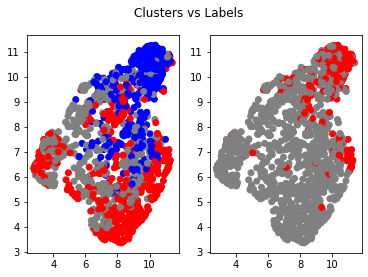

Cluster #  0 sized:  2522
[('GCS_last', 0.253), ('Age', 0.145), ('BUN_first', 0.101), ('CSRU', 0.073), ('GCS_first', 0.06), ('RespRate_median', 0.043), ('BUN_last', 0.023), ('PaO2_first', 0.02), ('RespRate_highest', 0.017), ('HR_highest', 0.017)]

Cluster #  1 sized:  2258
[('GCS_last', 0.236), ('Age', 0.116), ('BUN_last', 0.095), ('GCS_first', 0.079), ('PaO2_first', 0.042), ('CSRU', 0.037), ('RespRate_highest', 0.033), ('BUN_first', 0.025), ('FiO2_last', 0.023), ('HR_highest', 0.022)]

Cluster #  2 sized:  1970
[('GCS_last', 0.29), ('BUN_last', 0.115), ('Age', 0.06), ('HCO3_last', 0.039), ('SAPS-I', 0.037), ('HR_highest', 0.034), ('CSRU', 0.034), ('Bilirubin_last', 0.033), ('BUN_first', 0.031), ('Glucose_last', 0.021)]



In [85]:
####################################################################################
####################################################################################
####################################################################################
################################### Feature Imp. ###################################
####################################################################################
####################################################################################
####################################################################################

plot(model, torch.FloatTensor(X_train).to(args.device), y_train, labels=None)

regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]
qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
q_train = qs[0]
cluster_ids = torch.argmax(q_train, axis=1)
preds_e = torch.zeros((len(z_train), 2))
feature_importances = np.zeros((args.n_clusters, args.input_dim))

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    # X_cluster = z_test[cluster_id]
    X_cluster = z_train
    cluster_preds = model.classifiers[j][0](X_cluster)
    # print(q_test, cluster_preds[:,0])
    preds_e[:,0] += q_train[:,j]*cluster_preds[:,0]
    preds_e[:,1] += q_train[:,j]*cluster_preds[:,1]

for j in range(model.n_clusters):
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = X_train[cluster_id]
    if args.attention == True:
        y_cluster = preds_e[cluster_id][:,1]
    else:
        y_cluster = preds[cluster_id][:,1]

    # Some test data might not belong to any cluster
    if len(cluster_id) > 0:
        regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
        best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
        feature_importances[j,:] = regs[j].feature_importances_
        print("Cluster # ", j, "sized: ", len(cluster_id))
        print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
        print("=========================\n")


## Baseline Model

In [ ]:
f1_scores, auc_scores = [], []

for r in range(5):
    m = NNClassifier(args, input_dim=89)
    device = args.device

    N_EPOCHS = args.n_epochs
    es = EarlyStopping(dataset=args.dataset, path="./pretrained_model/checkpoint_base")

    kmeans = KMeans(n_clusters=args.n_classes, n_init=20)

    for e in range(1, N_EPOCHS):
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0
        m.train()
        nmi, acc, ari = 0, 0, 0

#         for X_batch, y_batch, _ in train_loader:
        X_batch, y_batch = torch.FloatTensor(X_train), torch.Tensor(y_train).type(torch.LongTensor)
        y_pred, train_loss = m.fit(X_batch, y_batch)
        epoch_loss += train_loss

        f1 = f1_score(np.argmax(y_pred, axis=1), y_batch)
        acc = roc_auc_score(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()


        m.classifier.eval()
        val_pred = m(torch.FloatTensor(X_val).to(args.device))
        val_loss = nn.CrossEntropyLoss(reduction='mean')(val_pred, torch.Tensor(y_val).type(torch.LongTensor))

        val_f1 = f1_score(torch.argmax(val_pred, axis=1), y_val)
        val_auc = roc_auc_score(y_val, val_pred[:,1].data.cpu().numpy())
        es([val_f1, val_auc], m)

        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
            f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
            f'Val F1: {val_f1:.3f} | Val Acc: {val_auc:.3f} | Val Loss: {val_loss:.3f}')

        if es.early_stop == True:
            break


    ###################################### Testing #####################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data")

    # Load best model trained from local training phase
    m = es.load_checkpoint(m)
    m.classifier.eval()
    test_pred = m.classifier(torch.FloatTensor(X_test))
    test_loss = nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.Tensor(y_test).type(torch.LongTensor))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)
    test_auc = roc_auc_score(y_test, test_pred[:,1].detach().numpy())
    f1_scores.append(test_f1)
    auc_scores.append(test_auc)
    
    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
        f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
        f'Test F1: {test_f1:.3f} | Test Acc: {test_auc:.3f} | Test Loss: {test_loss:.3f}')


#     reg = GradientBoostingRegressor(random_state=0)

#     reg.fit(X_test, y_test)
#     best_features = np.argsort(reg.feature_importances_)[::-1][:10]
#     print("Best Features ")
#     print(column_names[best_features])
#     print("=========================\n")
print(f1_scores, auc_scores)
print("Avg. Test F1 = {:.3f}, AUC = {:.3f}".format(np.average(f1_scores), np.average(auc_scores)))